In [208]:
import pandas as pd
matches = pd.read_csv("matches.csv", index_col=0)
odds = pd.read_csv(r"C:\Users\krawc\OneDrive\Documents\code\pythons\predictor\data\match_w_odds_2223.csv", index_col=[0,1,2])
ranked = pd.read_csv(r"C:\Users\krawc\OneDrive\Documents\code\pythons\predictor\data\ranked_mets_2122plus.csv", index_col=[0])

matches

,team,date,time,round,day,venue,result,gf,ga,opponent,...,formation,referee,match_report,notes,sh,sot,dist,fk,pk,pkatt
0,Arsenal,2022-08-05,20:00:00,Matchweek 1,Fri,Away,W,2,0,Crystal Palace,...,4-3-3,Anthony Taylor,/en/matches/e62f6e78/Crystal-Palace-Arsenal-Au...,NaN,10,2,14.6,1,0,0
1,Arsenal,2022-08-13,15:00:00,Matchweek 2,Sat,Home,W,4,2,Leicester City,...,4-3-3,Darren England,/en/matches/7483b97f/Arsenal-Leicester-City-Au...,NaN,19,7,13.0,0,0,0
2,Arsenal,2022-08-20,17:30:00,Matchweek 3,Sat,Away,W,3,0,Bournemouth,...,4-3-3,Craig Pawson,/en/matches/7f11dd9e/Bournemouth-Arsenal-Augus...,NaN,14,6,14.8,0,0,0
3,Arsenal,2022-08-27,17:30:00,Matchweek 4,Sat,Home,W,2,1,Fulham,...,4-3-3,Jarred Gillett,/en/matches/8b69fd2d/Arsenal-Fulham-August-27-...,NaN,22,8,15.5,1,0,0
4,Arsenal,2022-08-31,19:30:00,Matchweek 5,Wed,Home,W,2,1,Aston Villa,...,4-3-3,Robert Jones,/en/matches/cc235aad/Arsenal-Aston-Villa-Augus...,NaN,22,8,16.3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,Wolves,2023-04-29,15:00:00,Matchweek 34,Sat,Away,L,0,6,Brighton,...,4-4-2,David Coote,/en/matches/21f920e0/Brighton-and-Hove-Albion-...,NaN,10,2,18.7,0,0,0
756,Wolves,2023-05-06,15:00:00,Matchweek 35,Sat,Home,W,1,0,Aston Villa,...,4-4-2,Stuart Attwell,/en/matches/217a7faf/Wolverhampton-Wanderers-A...,NaN,6,2,17.6,0,0,0
757,Wolves,2023-05-13,15:00:00,Matchweek 36,Sat,Away,L,0,2,Manchester Utd,...,4-4-2,John Brooks,/en/matches/f5d61382/Manchester-United-Wolverh...,NaN,5,0,10.5,0,0,0
758,Wolves,2023-05-20,15:00:00,Matchweek 37,Sat,Home,D,1,1,Everton,...,4-4-2,David Coote,/en/matches/ff2b58c3/Wolverhampton-Wanderers-E...,NaN,13,5,17.9,1,0,0


In [209]:
def add_key_col(hist):
    ew_game=hist['date'] +' ' + hist['team']+'-' + hist['opponent']
    # ew_game=hist['date'].dt.date.astype('string') +' ' + hist['home_team']+'-' + hist['away_team']
    return ew_game

def prep_matches(matches):
    # matches=matches.drop('notes',axis=1)
    matches=matches.iloc[:,:10]
    # matches["date"] = pd.to_datetime(matches["date"])
    matches["target"] = (matches["result"] == "W").astype("int")
    matches["venue_code"] = matches["venue"].astype("category").cat.codes
    # matches["opp_code"] = matches["opponent"].astype("category").cat.codes
    # matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")
    # matches["day_code"] = matches["date"].dt.dayofweek

    wdl={'W':3,'D':1,'L':0}
    # matches['points']=matches['result'].map(wdl)
    return matches

def eliminate_outliers(matches,trsh=0.25):
    c1=matches.target==1
    c2=matches.pAvgH<trsh
    matches=matches[~(c1&c2)]#['pAvgH'].quantile(.2)
    #remove odds
    matches=matches.iloc[:,:-6]
    return matches

def keysplit(text):
    sd,st=text.split(' ',1)
    sh,sa=st.split('-',1)
    return sd,sh,sa

def reverse_key(oldkey):
    sd,sh,sa = keysplit(oldkey)
    return sd + ' ' + sa + '-' + sh

def reverse_odds_df(odds2):
    odds3=odds2.copy()
    odds3.index=odds3.index.map(reverse_key)
    odds3['AvgH'],odds3['AvgA']=odds3['AvgA'],odds3['AvgH']
    odds3['pAvgH'],odds3['pAvgA']=odds3['pAvgA'],odds3['pAvgH']
    return odds3

def prep_odds(odds):
    odds2=odds.droplevel([0,1]).iloc[:,-6:] 

    odds3=reverse_odds_df(odds2)
    
    odds23=pd.concat([odds2,odds3])
    return odds23

def merge_matches_odds(matches,odds):
    matches['key']=add_key_col(matches)
    matches=matches.set_index('key')
    
    matches2=matches.join(odds).reset_index(drop=True)
    return matches2

def rolling_averages(group, cols, new_cols,window=3):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(window, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group
    # # EXAMPLE
    # grouped_matches = matches.groupby("team")
    # group = grouped_matches.get_group("Manchester City").sort_values("date")
    # rolling_averages(group, cols, new_cols)

def add_rolling(matches):
    cols = ["gf", "ga",'points']
    new_cols = [f"{c}_rolling" for c in cols]

    matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))
    matches_rolling = matches_rolling.droplevel('team')
    matches_rolling = matches_rolling.reset_index(drop=True)

    matches_rolling = matches_rolling.drop('points',axis=1)
    return matches_rolling 

def merge_matches_metrics(matches,ranked):
    full=matches.set_index('team').join(ranked).reset_index(drop=False,names='team')
    full=full.set_index('opponent').join(ranked,rsuffix='_opo').reset_index(drop=False,names='opponent')
    return full

def calc_diffs(full):
    rankedlen=17
    startcol=12+0
    
    sc=startcol
    rl=rankedlen

    team_cols=full.columns[sc:sc+rl]
    opp_cols=full.columns[sc+rl:sc+rl+rl]
    new_names=[x +'_diff' for x in team_cols]
    
    diff_vals=full[team_cols].values-full[opp_cols].values
    diff_df=pd.DataFrame(diff_vals,index=full[team_cols].index,columns=new_names)

    full=full.join(diff_df)
    return full

In [210]:
matches=prep_matches(matches)
odds=prep_odds(odds)


In [211]:
matches2=merge_matches_odds(matches,odds)
# matches2=add_rolling(matches2)
matches2=eliminate_outliers(matches2)

full=merge_matches_metrics(matches2,ranked)
full=calc_diffs(full)
# full['r_ad']=full['atks']/full['defs_opo']
# full['r_err']=full['offsucc']/full['deferror_opo']

In [212]:
full.columns
cols_base=['opponent', 'team', 'date', 'time', 'round', 'day', 'venue', 'result', 'gf', 'ga','venue_code','target']

cols_diffs=['goalie_diff', 'defs_diff', 'mids_diff', 'atks_diff', 'offdeff_diff',
       'intensity_diff', 'dirspeed_diff', 'deads_diff', 'press_diff',
       'contra_diff', 'buildup_diff', 'progress_diff', 'carr_diff',
       'wings_diff', 'agresive_diff', 'deferror_diff', 'offsucc_diff']


cols_sel=cols_diffs + ['venue_code']
# 7324 7368
cols_sel.remove('offsucc_diff')
# 736
cols_sel.remove('progress_diff')
cols_sel.remove('atks_diff')
cols_sel.remove('mids_diff')
# 723 741

X_base=full[cols_sel]

In [213]:
cols_sel

['goalie_diff',
 'defs_diff',
 'offdeff_diff',
 'intensity_diff',
 'dirspeed_diff',
 'deads_diff',
 'press_diff',
 'contra_diff',
 'buildup_diff',
 'carr_diff',
 'wings_diff',
 'agresive_diff',
 'deferror_diff',
 'venue_code']

In [214]:
from sklearn.model_selection import train_test_split
# predictors = ["venue_code", "opp_code", "hour", "day_code"]
X_train, X_test, y_train, y_test = train_test_split(X_base, full['target'], test_size=0.3, random_state=42)

In [215]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

In [216]:
# befroe rolling 0.6622807017543859
error = accuracy_score(y_test, preds)
error

0.6972477064220184

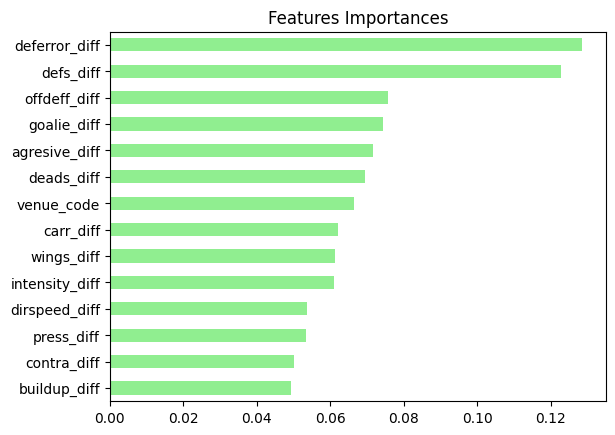

In [217]:
cols=X_base.columns
import matplotlib.pyplot as plt
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_, index= cols)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [218]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train, y_train)

# Predict and print the label for the new data point X_new
y_pred = knn.predict(X_test)


In [219]:
#  Print the accuracy
print(knn.score(X_test, y_test))

#evaluating model

# Import necessary modules
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7064220183486238
[[119  21]
 [ 43  35]]
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       140
           1       0.62      0.45      0.52        78

    accuracy                           0.71       218
   macro avg       0.68      0.65      0.66       218
weighted avg       0.70      0.71      0.69       218



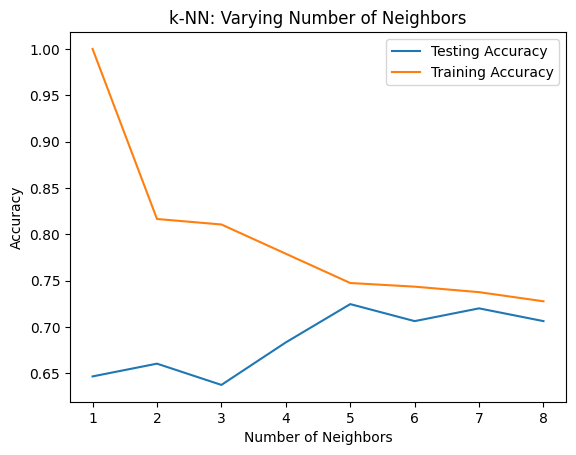

In [220]:
#how many neighbours
import numpy as np
import matplotlib.pyplot as plt
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train,y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [221]:
# Logistic Regression
# Import the necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
# Import the necessary modules
from sklearn.linear_model import LogisticRegression


# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('lreg', LogisticRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set: knn_scaled
lreg = pipeline.fit(X_train, y_train)


# Compute and print metrics
print(lreg.score(X_test, y_test))

# Predict the labels of the test set: y_pred
y_pred = lreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# befroe rolling 0.7236842105263158
# [[110  24]
#  [ 39  55]]


0.7339449541284404
[[114  26]
 [ 32  46]]
              precision    recall  f1-score   support

           0       0.78      0.81      0.80       140
           1       0.64      0.59      0.61        78

    accuracy                           0.73       218
   macro avg       0.71      0.70      0.71       218
weighted avg       0.73      0.73      0.73       218



In [222]:
# # import pickle
# # s = pickle.dumps(clf)
# # clf2 = pickle.loads(s)

# from joblib import dump, load
# dump(lreg, 'model71_2223hist2.joblib') 
# # lreg = load('model71_2223hist.joblib')

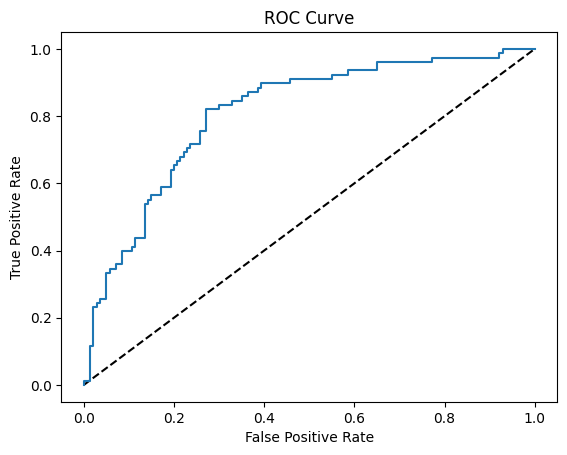

In [223]:
#ROC curve
import matplotlib.pyplot as plt

# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = lreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

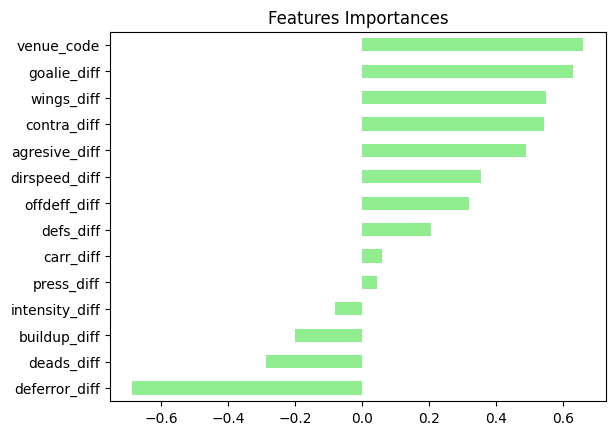

In [224]:
cols=X_base.columns
import matplotlib.pyplot as plt
# Create a pd.Series of features importances
importances = pd.Series(data=lreg.steps[1][1].coef_[0], index= cols)[:25]

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [225]:
# GridSearch

# Setup the pipeline
steps = [('scaler', StandardScaler()),
        ('lreg', LogisticRegression())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
c_space = np.logspace(-5, 8, 15)
# parameters = {'lreg__C': c_space}
parameters = [    
    {'lreg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'lreg__C' : np.logspace(-4, 4, 20),
    # 'lreg__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    # 'lreg__max_iter' : [100, 1000,2500, 5000]
    }
]

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

# 0.75 {'lreg__C': 0.23357214690901212, 'lreg__penalty': 'l2'}

c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\krawc\OneDrive\Docu

Accuracy: 0.7339449541284404
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       140
           1       0.67      0.50      0.57        78

    accuracy                           0.73       218
   macro avg       0.71      0.68      0.69       218
weighted avg       0.73      0.73      0.72       218

Tuned Model Parameters: {'lreg__C': 0.012742749857031334, 'lreg__penalty': 'l2'}


c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\krawc\OneDrive\Docu

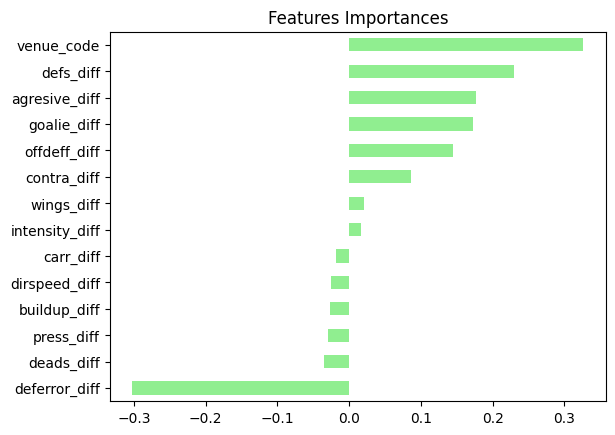

In [226]:
coefs=cv.best_estimator_.steps[1][1].coef_[0]
cols=cv.feature_names_in_
import matplotlib.pyplot as plt
# Create a pd.Series of features importances
importances = pd.Series(data=coefs, index= cols)[:25]

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [227]:
#CART - Classification and Regression Trees 
# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=6, random_state=1, criterion='entropy') #, criterion='gini'

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict test set labels
y_pred = dt.predict(X_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))

print(classification_report(y_test, y_pred))

Test set accuracy: 0.68
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       140
           1       0.56      0.54      0.55        78

    accuracy                           0.68       218
   macro avg       0.65      0.65      0.65       218
weighted avg       0.68      0.68      0.68       218



In [228]:
# Set seed for reproducibility
SEED=1

# Instantiate lr
lr = LogisticRegression(random_state=SEED)
# Instantiate knn
knn = KNeighborsClassifier(n_neighbors=2)
# Instantiate dt
dt = DecisionTreeClassifier(min_samples_leaf=0.13, random_state=SEED)

# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]



In [229]:
# Import VotingClassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier

# Instantiate a VotingClassifier vc 
vc = VotingClassifier(estimators=classifiers)     

# Fit vc to the training set
vc.fit(X_train, y_train)   

# Evaluate the test set predictions
y_pred = vc.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.3f}'.format(accuracy))

Voting Classifier: 0.739


In [230]:
# 50 drzew z rozna bootsrapowana data glosuje -> tworzy sie 50 tych samych modeli dopasowanych do innej kombincji danych
# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier

# Instantiate dt
dt = DecisionTreeClassifier(random_state=1)

# Instantiate bc
bc = BaggingClassifier(base_estimator=dt, n_estimators=50, random_state=1, oob_score=True)

# Fit bc to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate acc_test
acc_test = accuracy_score(y_test, y_pred)
# Evaluate OOB accuracy
acc_oob = bc.oob_score_

# Print acc_test and acc_oob
print('Test set accuracy: {:.3f}, OOB accuracy: {:.3f}'.format(acc_test, acc_oob))

print(classification_report(y_test, y_pred))

c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Test set accuracy: 0.706, OOB accuracy: 0.680
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       140
           1       0.61      0.50      0.55        78

    accuracy                           0.71       218
   macro avg       0.68      0.66      0.67       218
weighted avg       0.70      0.71      0.70       218



In [231]:
from sklearn.metrics import roc_auc_score
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

# Instantiate dt
dt = DecisionTreeClassifier(max_depth=2, random_state=1)

# Instantiate ada
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=200, random_state=1)

# Fit ada to the training set
ada.fit(X_train, y_train)

# Compute the probabilities of obtaining the positive class
y_pred_proba = ada.predict_proba(X_test)[:,1]

# Evaluate test-set roc_auc_score
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)
# Print roc_auc_score
print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


ROC AUC score: 0.67


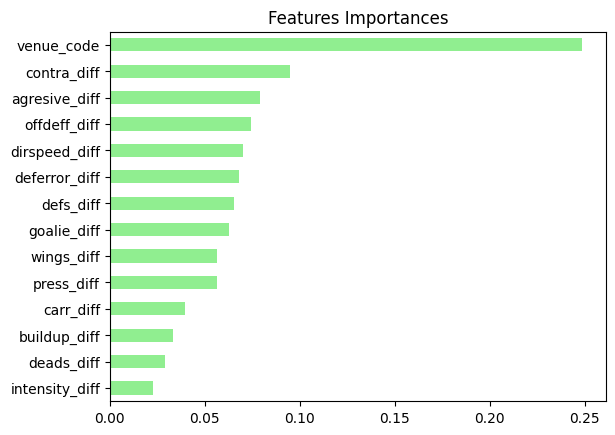

In [232]:
cols=X_base.columns
# Create a pd.Series of features importances
importances = pd.Series(data=ada.feature_importances_, index= cols)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

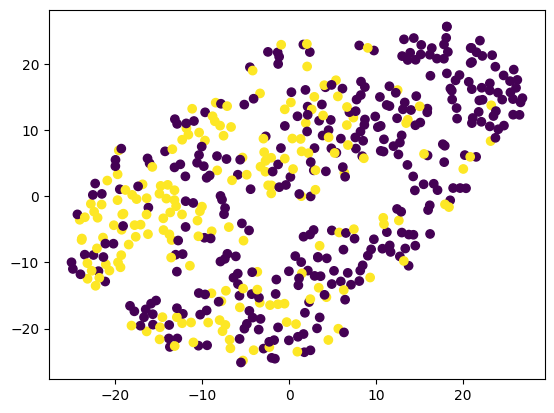

In [233]:
# Import TSNE
from sklearn.manifold import TSNE

# Create a TSNE instance: model
model = TSNE(learning_rate=200)

# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(X_train)

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1st feature: ys
ys = tsne_features[:,1]

# Scatter plot, coloring by variety_numbers
plt.scatter(xs,ys,c=y_train)
plt.show()

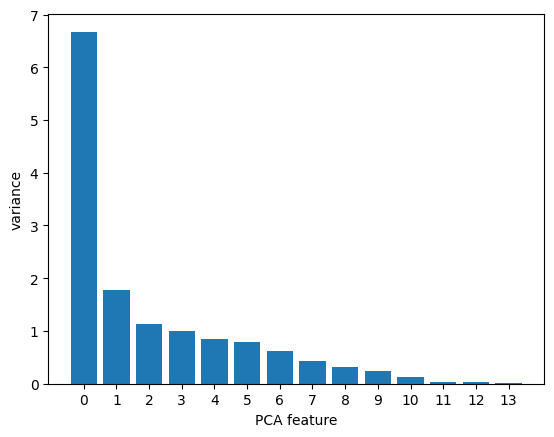

In [234]:
    # how many intrinsic dimensions

# Perform the necessary imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

# Fit the pipeline to 'samples'
pipeline.fit(X_train)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [235]:
    # how many intrinsic dimensions you have to set n_components - idealy to intrinsic dimention

# Perform the necessary imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=3)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

# Fit the pipeline to 'samples'
pipeline.fit(X_train)

# Transform the scaled samples: pca_features
pca_features = pipeline.transform(X_train)

# Print the shape of pca_features
print(X_train.shape)
print(pca_features.shape)

# This information is included in the pca attribute: components_. As described in the documentation, 
# pca.components_ outputs an array of [n_components, n_features], 
# so to get how components are linearly related with the different features you have to:
#wychodzi na to ze PC sa skorelowane z kazdym feature i sa ich oszacowaniem, wiec nie wiadomo z ktorego zrezygnowac

feature_names=X_base.columns
# Dump components relations with features:
pd.DataFrame(pca.components_,columns=feature_names,index = ['PC1','PC2','PC3'])


(507, 14)
(507, 3)


,goalie_diff,defs_diff,offdeff_diff,intensity_diff,dirspeed_diff,deads_diff,press_diff,contra_diff,buildup_diff,carr_diff,wings_diff,agresive_diff,deferror_diff,venue_code
PC1,-0.271976,-0.295103,-0.276464,-0.372653,0.275564,0.373606,-0.289317,-0.218420,-0.347617,0.192748,0.288653,0.032584,0.185025,-0.010290
PC2,0.295633,-0.113236,0.182962,0.065373,-0.357841,-0.097581,-0.255882,-0.223501,0.084843,0.436133,0.360891,-0.526855,-0.042612,-0.044560
PC3,0.111615,0.353711,0.206628,-0.087430,0.111546,0.044441,-0.189298,-0.428042,-0.159785,-0.111726,0.151872,0.265356,-0.656784,0.125549


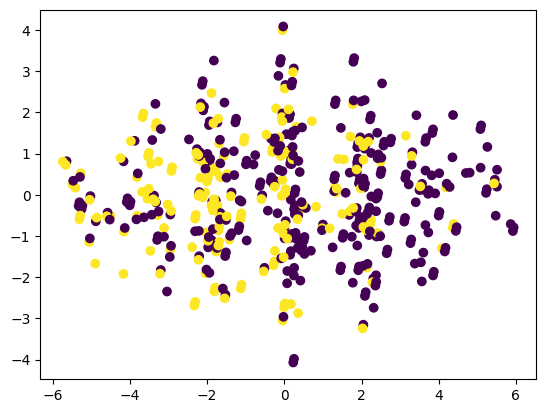

In [236]:
# Select the 0th feature: xs
xs = pca_features[:,0]

# Select the 1st feature: ys
ys = pca_features[:,1]

# Scatter plot, coloring by variety_numbers
plt.scatter(xs,ys,c=y_train)
plt.show()

In [237]:
# X_train, X_test, y_train, y_test = train_test_split(full[from_ranked], full['target'], test_size=0.3, random_state=42)

proba=lreg.predict_proba(X)[:,1]
pred=lreg.predict(X)

fin=full[full.columns[:11]]
fin['y_pred']=pred
fin['y_prob']=proba
fin


C:\Users\krawc\AppData\Local\Temp\ipykernel_9640\1098897255.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin['y_pred']=pred
C:\Users\krawc\AppData\Local\Temp\ipykernel_9640\1098897255.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin['y_prob']=proba


,opponent,team,date,time,round,day,venue,result,gf,ga,target,y_pred,y_prob
0,Arsenal,Aston Villa,2022-08-31,19:30:00,Matchweek 5,Wed,Away,L,1,2,0,0,0.061383
1,Arsenal,Aston Villa,2023-02-18,12:30:00,Matchweek 24,Sat,Home,L,2,4,0,0,0.196556
2,Arsenal,Bournemouth,2022-08-20,17:30:00,Matchweek 3,Sat,Home,L,0,3,0,0,0.051807
3,Arsenal,Bournemouth,2023-03-04,15:00:00,Matchweek 26,Sat,Away,L,2,3,0,0,0.014395
4,Arsenal,Brentford,2022-09-18,12:00:00,Matchweek 8,Sun,Home,L,0,3,0,0,0.203279
...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,Wolves,Southampton,2023-02-11,15:00:00,Matchweek 23,Sat,Home,L,1,2,0,0,0.310901
721,Wolves,Tottenham,2022-08-20,12:30:00,Matchweek 3,Sat,Home,W,1,0,1,1,0.715674
722,Wolves,Tottenham,2023-03-04,15:00:00,Matchweek 26,Sat,Away,L,0,1,0,0,0.402223
723,Wolves,West Ham,2022-10-01,17:30:00,Matchweek 9,Sat,Home,W,2,0,1,1,0.575595


In [238]:
# fin.to_csv('match_w_pred_2223diff.csv')